In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import ast
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import interact, Dropdown

In [2]:
movies_df = pd.read_csv("data/preprocessed/preprocessed_movies.csv")
for col in movies_df.columns:
    try:
        movies_df[col] = movies_df[col].apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) else x
        )
    except:
        pass


movies_df.head(5)

,title,languages,countries,genres,release_date,cold_war_side,character_western_bloc_representation,character_eastern_bloc_representation,western_bloc_values,eastern_bloc_values,theme
0,$,NaN,[Russia],"[Comedy, Crime, Drama]",1971,Western,"[Joe Collins, American bank security consultan...","[Dawn Divine, hooker with a heart of gold, cun...",[None],"[Resourcefulness, cleverness, individualism, h...",[None]
1,"$1,000 on the Black","[Italian, German]","[Germany, Italy]",[Western],1966,Eastern,[None],"[Sartana, villainous, oppressive, cruel, arche...","[Johnny Liston, justice, determination, resili...","[Justice, revenge, oppressed vs. oppressor, re...","[Terror, betrayal, familial conflict, crime, r..."
2,"$10,000 Blood Money",NaN,[Russia],"[Western, Drama]",1967,None,[None],[None],[None],[None],"[crime, betrayal, revenge, bounty hunter, heis..."
3,"$100,000 for Ringo",[Italian],[Italy],"[Western, Drama]",1965,None,[None],[None],[None],[None],"[Western, Civil War, mistaken identity, treasu..."
4,'Anna' i wampir,NaN,[Russia],[Crime],1982,None,[None],[None],[None],[None],"[murder mystery, horror, fog, Poland, 1960s]"


# Genre Analysis

## Bar Plots


C:\Users\karim\AppData\Local\Temp\ipykernel_7036\1391639297.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette="viridis")


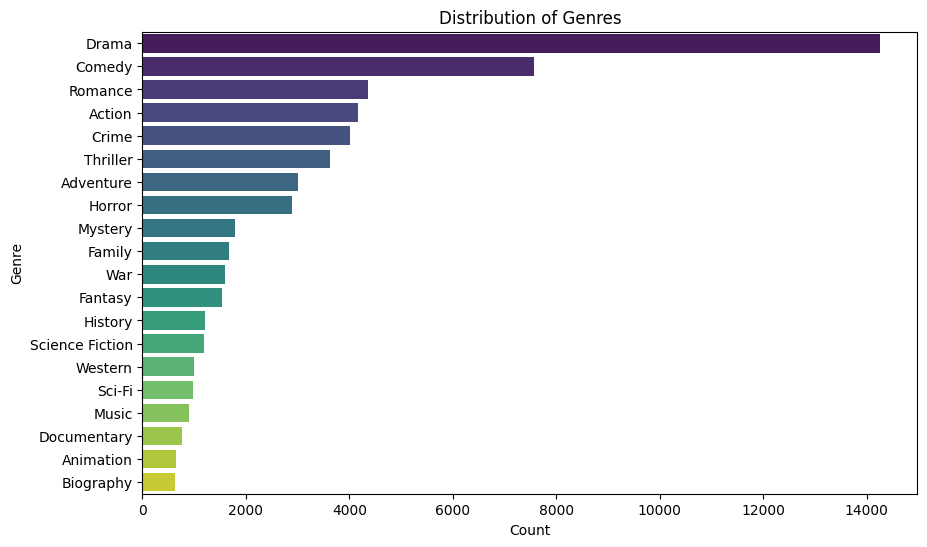

In [3]:
genres_df = movies_df[["countries", "cold_war_side", "genres", "release_date"]]
genres_df = genres_df.explode("genres")[genres_df.explode("genres") != "\\N"]
genres_df["genres"] = genres_df["genres"].str.title().str.strip()

genre_counts = genres_df["genres"].value_counts().head(20)
common_genres = genre_counts.head(12).index


# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette="viridis")
plt.title("Distribution of Genres")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.show()

In [4]:
def plot_distributions(
    western_counts,
    eastern_counts,
    title_western,
    title_eastern,
    ylabel="Genre",
    figsize=(20, 9),
    color_western="#1f77b4",
    color_eastern="#ff6347",
    log_scale=True,
):
    fig, axes = plt.subplots(1, 2, figsize=figsize)  # 1 row, 2 columns
    sns.set_style(style="whitegrid")

    # Western plot
    sns.barplot(
        x=western_counts.head(20).values,
        y=western_counts.head(20).index,
        color=color_western,
        ax=axes[0],
    )
    axes[0].set_title(title_western)
    axes[0].set_xlabel("Count")
    axes[0].set_ylabel(ylabel)
    if log_scale:
        axes[0].set_xscale("log")

    # Eastern plot
    sns.barplot(
        x=eastern_counts.head(20).values,
        y=eastern_counts.head(20).index,
        color=color_eastern,
        ax=axes[1],
    )
    axes[1].set_title(title_eastern)
    axes[1].set_xlabel("Count")
    axes[1].set_ylabel(ylabel)
    if log_scale:
        axes[1].set_xscale("log")

    plt.tight_layout()
    plt.show()

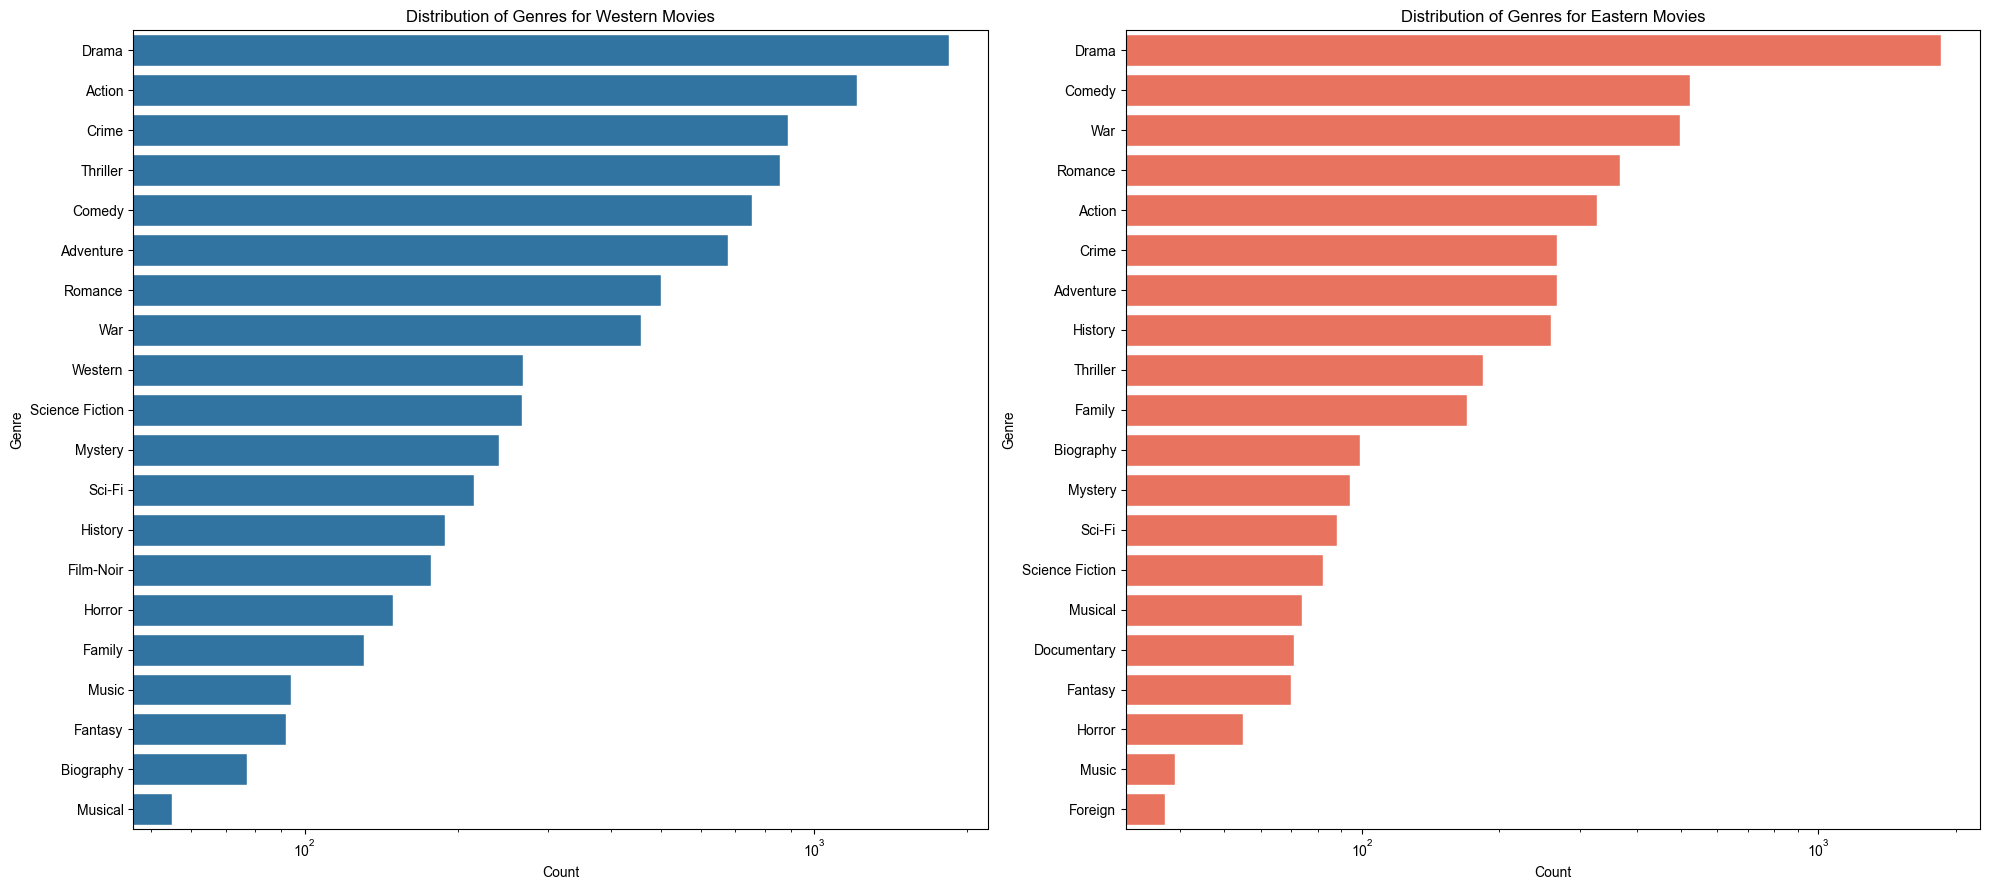

In [5]:
western_genre_counts = genres_df[genres_df["cold_war_side"] == "Western"][
    "genres"
].value_counts()
eastern_genre_counts = genres_df[genres_df["cold_war_side"] == "Eastern"][
    "genres"
].value_counts()

plot_distributions(
    western_genre_counts,
    eastern_genre_counts,
    title_western="Distribution of Genres for Western Movies",
    title_eastern="Distribution of Genres for Eastern Movies",
    ylabel="Genre",
)

In [6]:
def create_comparison_df(
    west_df,
    east_df,
    threshold,
    common_genres=[
        "Drama",
        "Action",
        "Comedy",
        "Crime",
        "Thriller",
        "War",
        "Adventure",
        "Romance",
        "History",
        "Science Fiction",
    ],
):
    comparison_df = pd.DataFrame({"Western": west_df, "Eastern": east_df}).fillna(0)

    comparison_df["relative_difference"] = (
        comparison_df["Eastern"] - comparison_df["Western"]
    ) / (comparison_df["Eastern"] + comparison_df["Western"])

    comparison_df["absolute_relative_difference"] = comparison_df[
        "relative_difference"
    ].abs()

    comparison_df["Eastern_Proportion"] = (
        comparison_df["Eastern"] / comparison_df["Eastern"].sum(axis=0) * 100
    )
    comparison_df["Western_Proportion"] = (
        comparison_df["Western"] / comparison_df["Western"].sum(axis=0) * 100
    )

    comparison_df["proportion_relative_difference"] = (
        comparison_df["Eastern_Proportion"] - comparison_df["Western_Proportion"]
    ) / (comparison_df["Eastern_Proportion"] + comparison_df["Western_Proportion"])
    comparison_df["absolute_proportion_relative_difference"] = comparison_df[
        "proportion_relative_difference"
    ].abs()

    comparison_df["total"] = comparison_df["Eastern"] + comparison_df["Western"]

    comparison_df = (
        comparison_df[
            (comparison_df["Eastern"] > threshold)
            | (comparison_df["Western"] > threshold)
        ]
        .sort_values("absolute_relative_difference", ascending=False)
        .head(20)
    )
    return comparison_df

In [7]:
genre_comparison = create_comparison_df(western_genre_counts, eastern_genre_counts, 20)
genre_comparison

,Western,Eastern,relative_difference,absolute_relative_difference,Eastern_Proportion,Western_Proportion,proportion_relative_difference,absolute_proportion_relative_difference,total
genres,,,,,,,,,
Film-Noir,177,12.0,-0.873016,0.873016,0.217391,1.903021,-0.794954,0.794954,189.0
Western,269,22.0,-0.848797,0.848797,0.398551,2.892162,-0.757772,0.757772,291.0
Tv Movie,25,3.0,-0.785714,0.785714,0.054348,0.268788,-0.663623,0.663623,28.0
Thriller,858,184.0,-0.646833,0.646833,3.333333,9.224815,-0.469136,0.469136,1042.0
Action,1212,327.0,-0.575049,0.575049,5.923913,13.030857,-0.374942,0.374942,1539.0
Crime,889,268.0,-0.536733,0.536733,4.855072,9.558112,-0.326301,0.326301,1157.0
Science Fiction,267,82.0,-0.530086,0.530086,1.485507,2.870659,-0.317975,0.317975,349.0
Documentary,24,71.0,0.494737,0.494737,1.286232,0.258037,0.665814,0.665814,95.0
Horror,149,55.0,-0.460784,0.460784,0.996377,1.601978,-0.233071,0.233071,204.0


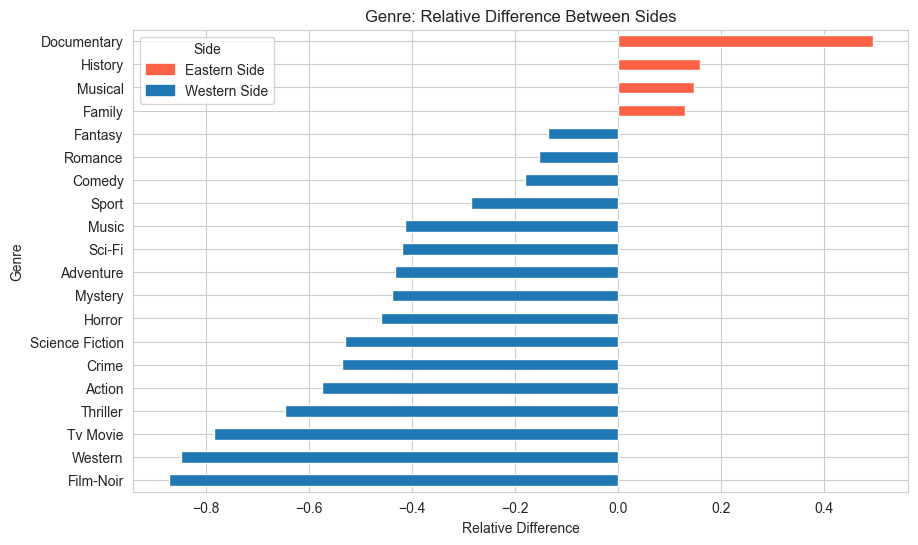

In [8]:
def plot_relative_difference(comparison_df, compared, abs=False, prop=False):
    column = "relative_difference"
    sort_column = "relative_difference"

    if prop:
        sort_column = "proportion_" + column
        column = "proportion_" + column
    if abs:
        column = "absolute_" + column

    comparison_df = comparison_df.sort_values(sort_column)
    comparison_df[column].plot(
        kind="barh",
        figsize=(10, 6),
        color=["#ff6347" if x > 0 else "#1f77b4" for x in comparison_df[sort_column]],
    )
    column = column.replace("_", " ").title()
    plt.title(f"{compared}: {column} Between Sides")
    plt.xlabel(f"{column}")
    plt.ylabel(f"{compared}")

    # Create custom legend
    legend_elements = [
        Patch(color="#ff6347", label="Eastern Side"),
        Patch(color="#1f77b4", label="Western Side"),
    ]
    plt.legend(handles=legend_elements, title="Side")
    plt.show()


plot_relative_difference(genre_comparison, "Genre", abs=False, prop=False)

## Time Series


In [9]:
western_genres_yearly_counts = (
    genres_df[genres_df["cold_war_side"] == "Western"]
    .explode("genres")
    .groupby("release_date")["genres"]
    .value_counts()
).reset_index()
eastern_genres_yearly_counts = (
    genres_df[genres_df["cold_war_side"] == "Eastern"]
    .explode("genres")
    .groupby("release_date")["genres"]
    .value_counts()
).reset_index()

eastern_genres_yearly_counts = eastern_genres_yearly_counts[
    eastern_genres_yearly_counts["genres"].isin(common_genres)
]
western_genres_yearly_counts = western_genres_yearly_counts[
    western_genres_yearly_counts["genres"].isin(common_genres)
]

In [10]:
def plot_genres_over_time(side_genres_counts, side):
    # Create the interactive line plot
    fig = px.line(
        side_genres_counts.reset_index(),
        x="release_date",
        y="count",
        color="genres",
        title=f"Genre Counts Over Time for {side} Movies",
        labels={"release_date": "Release Date", "Count": "Count", "Genre": "Genres"},
        template="plotly_white",
    )

    # Make all traces except War invisible by default
    fig.for_each_trace(
        lambda trace: (
            trace.update(visible="legendonly") if trace.name != "War" else None
        )
    )
    if side == "Eastern":
        fig.for_each_trace(lambda trace: trace.update(line_color="#ff6347"))
    elif side == "Western":
        fig.for_each_trace(lambda trace: trace.update(line_color="#1f77b4"))
    fig.show()

In [11]:
# Interactive widget
def interactive_plot(side_genres):
    if side_genres == "Western":
        plot_genres_over_time(western_genres_yearly_counts, "Western")
    elif side_genres == "Eastern":
        plot_genres_over_time(eastern_genres_yearly_counts, "Eastern")


# Use interact with a dropdown
interact(
    interactive_plot,
    side_genres=Dropdown(
        options=["Western", "Eastern"], value="Western", description="Region"
    ),
)

interactive(children=(Dropdown(description='Region', options=('Western', 'Eastern'), value='Western'), Output(…

<function __main__.interactive_plot(side_genres)>

In [12]:
def plot_genres_over_period(side_genres_counts, side):
    # Create the interactive line plot
    fig = px.line(
        side_genres_counts.reset_index(),
        x="period",
        y="count",
        color="genres",
        title=f"Genre Counts Over Different Periods for {side} Movies",
        labels={"period": "Release Date", "Count": "Count", "Genre": "Genres"},
        template="plotly_white",
    )

    # Make all traces except War invisible by default
    fig.for_each_trace(
        lambda trace: (
            trace.update(visible="legendonly") if trace.name != "War" else None
        )
    )
    if side == "Eastern":
        fig.for_each_trace(lambda trace: trace.update(line_color="#ff6347"))
    elif side == "Western":
        fig.for_each_trace(lambda trace: trace.update(line_color="#1f77b4"))
    fig.show()

In [13]:
bins = [1945, 1953, 1962, 1974, 1984, 1995]
labels = ["1945-1953", "1954-1962", "1963-1974", "1975-1984", "1985-1995"]

# bins = list(range(1945, 1996, 5))
# labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins) - 1)]

genres_df["period"] = pd.cut(genres_df["release_date"], bins, labels=labels, right=True)

period_counts = (
    genres_df.explode("genres")
    .groupby(["period", "cold_war_side"], observed=False)["genres"]
    .value_counts()
    .reset_index()
)
period_counts = period_counts[period_counts["genres"].isin(common_genres)]
eastern_period_counts = period_counts[
    period_counts["cold_war_side"] == "Eastern"
].reset_index()
western_period_counts = period_counts[
    period_counts["cold_war_side"] == "Western"
].reset_index()


# Interactive widget
def interactive_plot(side_genres):
    if side_genres == "Western":
        plot_genres_over_period(western_period_counts, "Western")
    elif side_genres == "Eastern":
        plot_genres_over_period(eastern_period_counts, "Eastern")


# Use interact with a dropdown
interact(
    interactive_plot,
    side_genres=Dropdown(
        options=["Western", "Eastern"], value="Western", description="Region"
    ),
)

interactive(children=(Dropdown(description='Region', options=('Western', 'Eastern'), value='Western'), Output(…

<function __main__.interactive_plot(side_genres)>

In [26]:
# Create Plotly figure function
def plot_genre_over_periods(df, genre):
    fig = px.bar(
        df[df["genres"] == genre],
        x="period",
        y="count",
        color="cold_war_side",
        title=f"{genre} Movie Counts Over Different Periods",
        labels={
            "period": "Period",
            "count": "Count",
            "genres": "Genres",
            "cold_war_side": "Side",
        },
        template="plotly_white",
        barmode="group",
    )

    fig.update_layout(
        hovermode="x unified",
        title=dict(x=0.5, xanchor="center"),
    )
    return fig


interact(
    lambda genre: plot_genre_over_periods(
        period_counts[period_counts["cold_war_side"].isin(["Western", "Eastern"])],
        genre,
    ),
    genre=Dropdown(options=common_genres, value="War", description="Genre"),
)

interactive(children=(Dropdown(description='Genre', index=10, options=('Drama', 'Comedy', 'Romance', 'Action',…

<function __main__.<lambda>(genre)>

# Theme Analysis

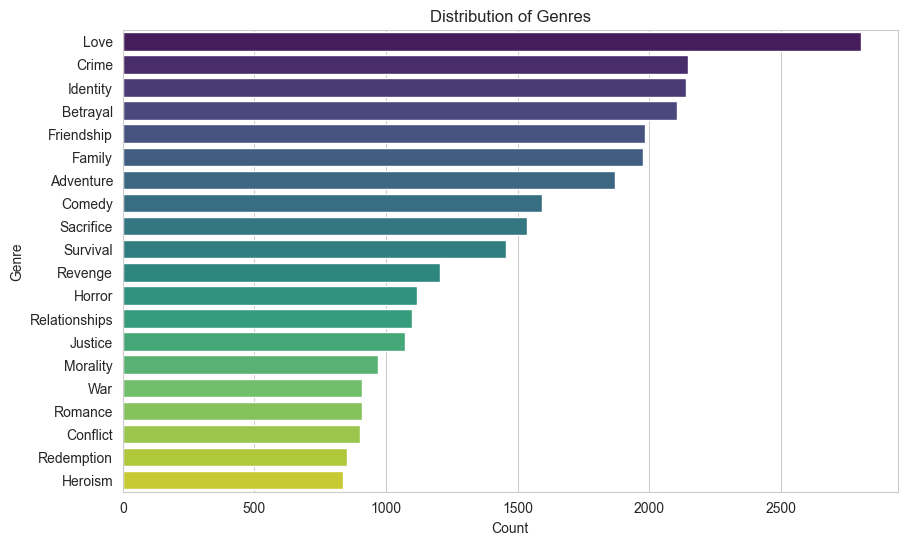

In [15]:
themes_df = (
    movies_df[["genres", "cold_war_side", "theme", "release_date"]]
    .explode("theme")
    .reset_index()
)
themes_df["theme"] = themes_df["theme"].str.title().str.strip()
themes_df = themes_df[themes_df["theme"] != "None"].dropna(subset="genres")

theme_counts = themes_df["theme"].value_counts().head(20)
# Plot the distribution
plt.figure(figsize=(10, 6))

sns.barplot(
    x=theme_counts.values,
    y=theme_counts.index,
    palette="viridis",
    hue=theme_counts.index,
)

plt.title("Distribution of Genres")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.show()

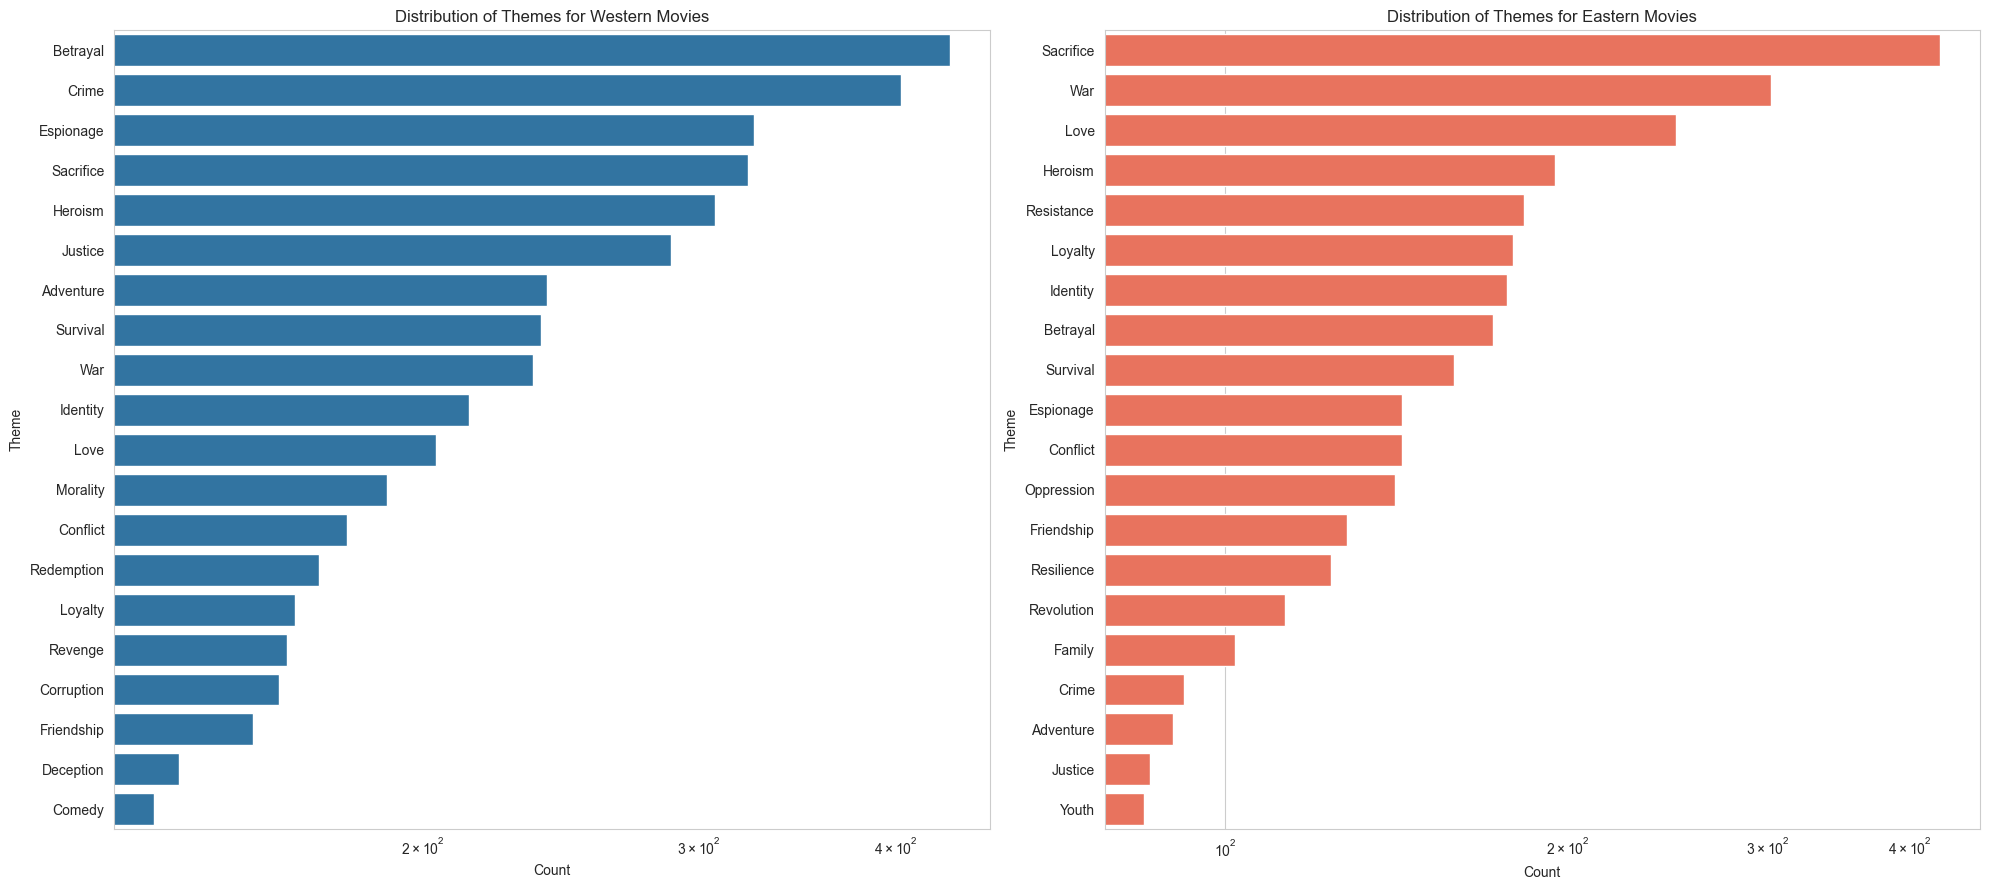

In [16]:
western_theme_counts = (
    themes_df[themes_df["cold_war_side"] == "Western"]["theme"]
    .explode("theme")
    .value_counts()
)
eastern_theme_counts = (
    themes_df[themes_df["cold_war_side"] == "Eastern"]["theme"]
    .explode("theme")
    .value_counts()
)

plot_distributions(
    western_theme_counts,
    eastern_theme_counts,
    title_western="Distribution of Themes for Western Movies",
    title_eastern="Distribution of Themes for Eastern Movies",
    ylabel="Theme",
)

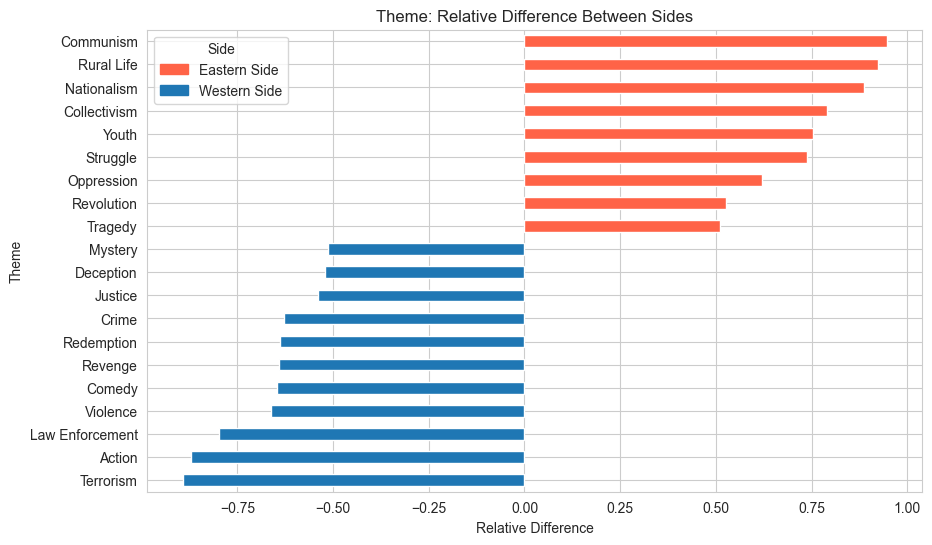

In [17]:
theme_comparison = create_comparison_df(western_theme_counts, eastern_theme_counts, 50)
plot_relative_difference(theme_comparison, "Theme")

In [18]:
eastern_war_themes = themes_df[
    (themes_df["cold_war_side"] == "Eastern")
    & (themes_df["genres"].apply(lambda x: "War" in x))
]
western_war_themes = themes_df[
    (themes_df["cold_war_side"] == "Western")
    & (themes_df["genres"].apply(lambda x: "War" in x))
]
western_war_themes_counts = western_war_themes["theme"].value_counts()
eastern_war_themes_counts = eastern_war_themes["theme"].value_counts()

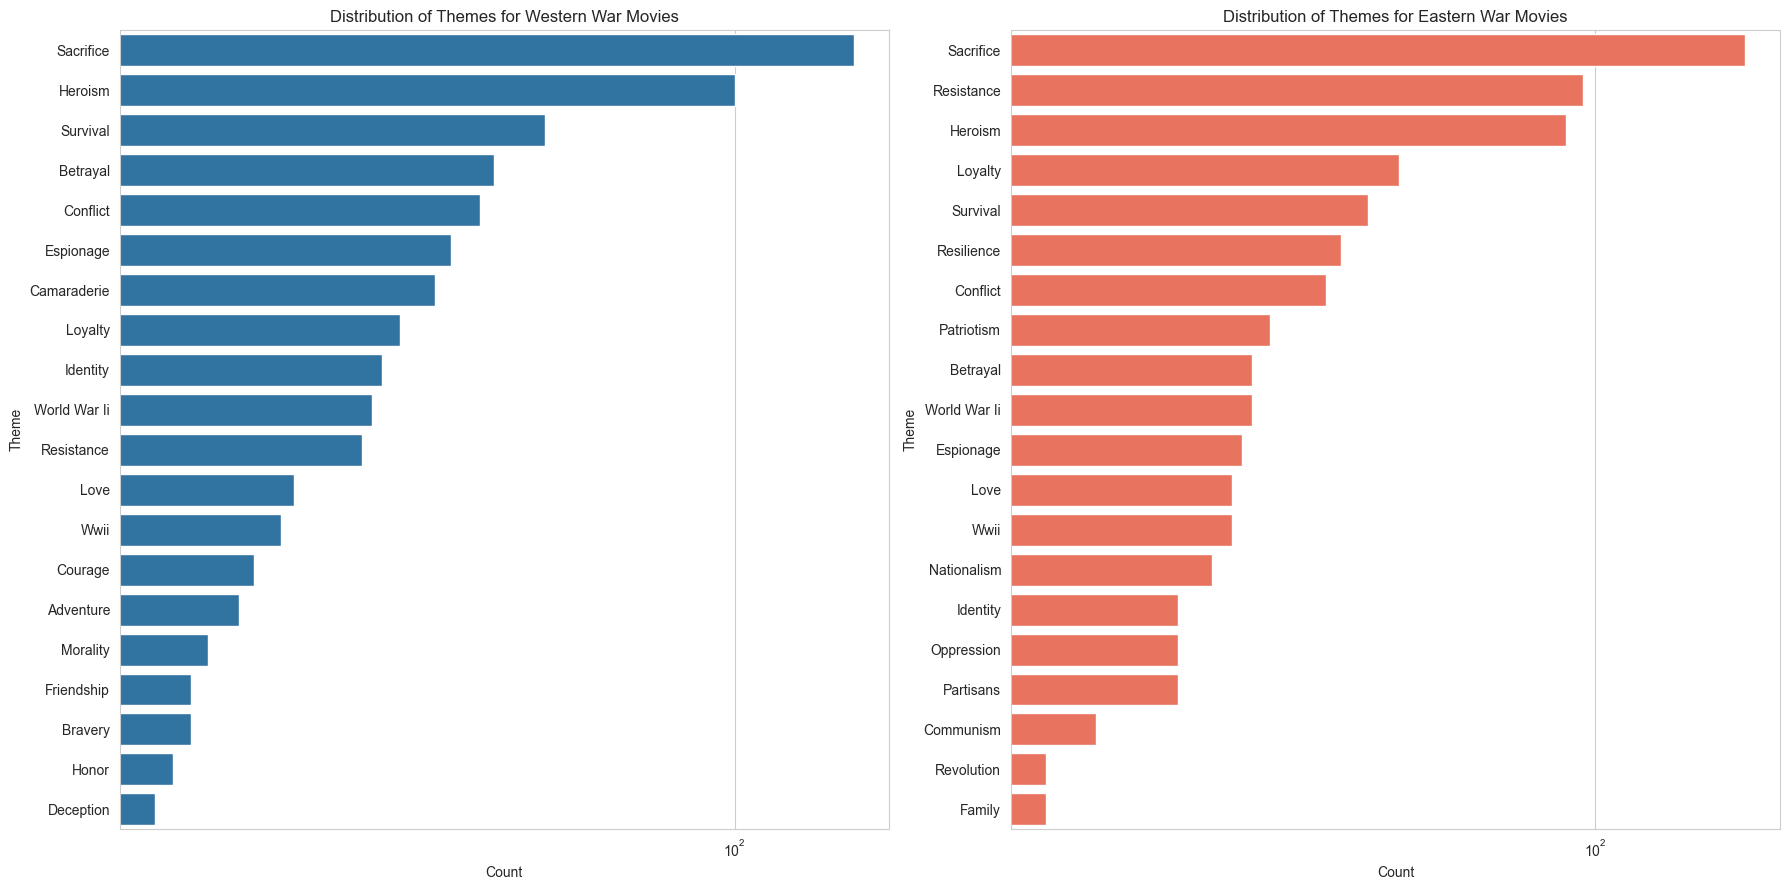

In [19]:
# remove war from themes
western_war_themes_counts = western_war_themes_counts[
    western_war_themes_counts.index != "War"
]
eastern_war_themes_counts = eastern_war_themes_counts[
    eastern_war_themes_counts.index != "War"
]

plot_distributions(
    western_war_themes_counts,
    eastern_war_themes_counts,
    title_western="Distribution of Themes for Western War Movies",
    title_eastern="Distribution of Themes for Eastern War Movies",
    ylabel="Theme",
    figsize=(18, 9),
)

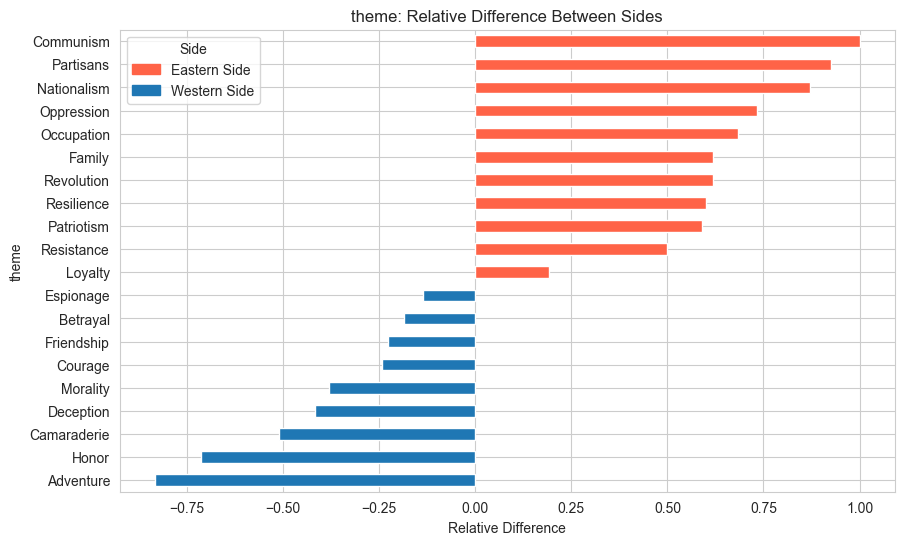

In [23]:
war_theme_comparison = create_comparison_df(
    western_war_themes_counts, eastern_war_themes_counts, 15
)


plot_relative_difference(war_theme_comparison, "theme")